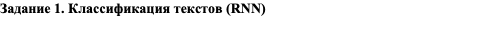

В качестве датасета использовались отзывы и рейтинг кафе и ресторанов Москвы в Яндекс.Картах

In [1]:
# !pip install tensorflow
# !pip install torchtext

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from nltk.corpus import stopwords
from torch.utils.data import DataLoader, TensorDataset
from nltk.tokenize import word_tokenize
import re
from collections import Counter


# Убедитесь, что все необходимые модули загружены
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Загрузка данных
df = pd.read_csv('reviews_clean.csv')

In [4]:
df

,Place,Author,Date,Review,Advantages,Disadvantages,Rating
0,Клуб Hot Collection / Хот Коллекшн,Александр Иванов,2023-09-15,"Мне нравится декор и освещение в этом клубе, х...",Не указано,Не указано,5.0
1,Ресторан Birds,Наталия,2023-09-14,Отличное место!!! Все суппер!!! Очень понравил...,Вид из окна,официант САВЧЕНКО ЕГОР ТРЕБОВАЛ В ГРУБОЙ ФОРМЕ...,3.9
2,Клуб Hot Collection / Хот Коллекшн,alasad,2023-09-14,Очень замечательное место с прекрасными видами...,"Очень замечательные услуги, красивые девушки, ...",ничего,5.0
3,Банкетный зал Сосны в отеле Роял Зенит,StasFoodLover,2023-09-13,Классное место! Атмосфера приятная и расслабле...,Общая атмосфера и кухня,Не заметили,5.0
4,Клуб Hot Collection / Хот Коллекшн,"Эмма, Эмма",2023-09-13,"Мне понравилась праздничная атмосфера, веселье...","Веселое место, музыка, энтузиазм и очень прием...",Я не нашел никаких минусов,5.0
...,...,...,...,...,...,...,...
12826,Ресторан Sixty / Сиксти,МакВас,2016-06-12,Поменяли шефа - стало поинтереснее. Цены все т...,Не указано,Не указано,5.0
12827,Ресторан У Пиросмани,marinabelorusova,2016-06-12,Была на прошлой неделе в ресторане. Не в первы...,Не указано,Не указано,5.0
12828,Ресторан Дворец Султана (Домодедово),oshvets,2016-06-12,Красивое уютное местечко в удобном месте город...,Не указано,Не указано,4.0
12829,Ресторан La Marée / Ла Маре (на Проточном),tim,2016-05-12,"Отличный ресторан, красивый интерьер к новому ...",Не указано,Не указано,5.0


In [5]:
# Упрощаем задачу — метка тональности положительная, если рейтинг >= 4, иначе отрицательная
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)
df = df[['Review', 'Sentiment']]

In [6]:
# Стоп-слова
stop_words = set(stopwords.words('russian'))

# Предобработка текста
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Убираем пунктуацию
    tokens = word_tokenize(text.lower())  # Токенизация + нижний регистр
    tokens = [word for word in tokens if word not in stop_words]  # Удаление стоп-слов
    return ' '.join(tokens)

df['Processed_Review'] = df['Review'].apply(preprocess_text)

# Разделение на текст и метки
texts = df['Processed_Review'].values
labels = df['Sentiment'].values

<ipython-input-6-dcf09e8ffb6e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed_Review'] = df['Review'].apply(preprocess_text)


In [7]:
texts

array(['нравится декор освещение клубе хорошая звуковая система говоря качестве еды приятной атмосфере',
       'отличное место суппер очень понравилось конце вечера расчете оплаты официант требовал чаевые желание оставлять чай сразу исчезло след прозвучала фр',
       'очень замечательное место прекрасными видами замечательным обслуживанием предлагает множество вкусных блюд множество редких видов алкоголя также прекрасную праздничную атмосферу красивых д',
       ...,
       'красивое уютное местечко удобном месте города цены адекватные кухня кавказская европейская вкусно обслуживание внимательное территория ухоженная парковка рекомендую посещения сем',
       'отличный ресторан красивый интерьер новому году ощущение новогодней сказке живая музыка потрясающее очень вкусный ужин хорошее обслуживание рекомендуем романтического св',
       '5 5 несколько заказывали треску осеннего меню'], dtype=object)

In [8]:
# Токенизация и создание индексов
def build_vocab(texts):
    flat_tokens = [token for text in texts for token in text.split()]
    vocab = Counter(flat_tokens)
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(vocab.items())}  # Индексация слов
    vocab['<pad>'] = 0  # Добавление токена паддинга
    return vocab

# Пример текста
texts = df['Processed_Review'].values  # Ваши тексты

# Создание словаря
vocab = build_vocab(texts)

# Функция преобразования текста в индексы
def text_to_indices(text, vocab, max_len=100):
    indices = [vocab.get(word, vocab['<pad>']) for word in text.split()]
    return indices[:max_len] + [vocab['<pad>']] * (max_len - len(indices))

# Преобразуем тексты в числовые последовательности
sequences = [text_to_indices(text, vocab) for text in texts]

# Добавляем паддинг для одинаковой длины последовательностей
max_len = 100  # Максимальная длина последовательности
X = [seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]
X = np.array(X)

# Преобразуем метки
y = np.array(labels)

# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуем в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Загружаем данные в DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Берем последний выход из RNN
        out = self.fc(out)
        return out

# Параметры модели
embedding_dim = 128
hidden_dim = 128
output_dim = 2  # Положительный и отрицательный класс

model = RNNModel(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim)


In [10]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)

        # Вычисление потерь и обратное распространение ошибки
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

Epoch 1/5, Loss: 0.5030
Epoch 2/5, Loss: 0.4979
Epoch 3/5, Loss: 0.4985
Epoch 4/5, Loss: 0.4992
Epoch 5/5, Loss: 0.4977


In [11]:
# Оценка модели
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Метрики
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.80
Precision: 0.80
Recall: 1.00


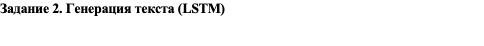

In [1]:
import numpy as np
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
import random
import sys
from nltk.corpus import stopwords
import nltk

# Загрузка стоп-слов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Шаг 1. Загрузка данных
with open("dostoevsky.txt", "r", encoding="utf-8") as file:
    text = file.read().lower()

# Шаг 2. Предобработка текста
# Убираем знаки препинания и создаем список слов

punctuation_to_remove = string.punctuation + "—"

text = text.translate(str.maketrans('', '', punctuation_to_remove))
words = text.split()


# Убираем стоп-слова
words = [word for word in words if word not in stop_words]

# Создадим словарь для индексации слов
word_to_index = {word: i for i, word in enumerate(set(words))}
index_to_word = {i: word for word, i in word_to_index.items()}

# Преобразуем текст в последовательности
seq_length = 3  # уменьшили длину последовательности
sequences = []

for i in range(len(words) - seq_length):
    sequences.append([word_to_index[word] for word in words[i:i+seq_length]])

# Подготовим данные для обучения
X = np.array([seq[:-1] for seq in sequences])
y = np.array([seq[-1] for seq in sequences])

# Шаг 3. Построение упрощенной модели LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], 1)))  # Используем только один LSTM слой с 64 нейронами
model.add(Dropout(0.2))  # Добавляем Dropout для предотвращения переобучения
model.add(Dense(len(word_to_index), activation='softmax'))  # Выходной слой
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

# Изменяем форму X для LSTM
X = np.expand_dims(X, axis=-1)

In [8]:
# Обучение модели
model.fit(X, y, batch_size=128, epochs=5)

Epoch 1/5
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 109s 14ms/step - loss: 10.3580
Epoch 2/5
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 10.1267
Epoch 3/5
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 108s 14ms/step - loss: 10.3364
Epoch 4/5
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - loss: 10.1908
Epoch 5/5
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 143s 14ms/step - loss: 10.5255


In [4]:
model.save('model.h5')
# model.save('model')

In [9]:
def generate_text(model, seed_text, num_words=50):
    result = seed_text
    for _ in range(num_words):
        # Токенизация начального текста
        tokenized_seed = [word_to_index.get(word, 0) for word in seed_text.split()[-seq_length+1:]]

        # Дополнение последовательности до нужной длины
        while len(tokenized_seed) < seq_length - 1:
            tokenized_seed.insert(0, 0)

        tokenized_seed = np.expand_dims(tokenized_seed, axis=0)

        # Предсказание следующего слова
        predicted_probs = model.predict(tokenized_seed, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)

        # Проверка предсказания на корректность
        predicted_word = index_to_word.get(predicted_index, "<UNKNOWN>")
        if predicted_word == "—" or predicted_word == "<UNKNOWN>":
            continue  # Пропускаем некорректные предсказания

        # Добавление слова в результат
        result += ' ' + predicted_word
        seed_text += ' ' + predicted_word

    return result


In [13]:
seed_text = "федор михайлович"
generated_text = generate_text(model, seed_text, num_words=5)
print(generated_text)


федор михайлович это это это это это


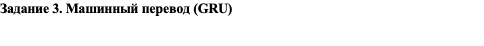

In [7]:
# !pip install torchtext==0.6
# !pip install datasets
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [3]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import spacy

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from nltk.translate.bleu_score import sentence_bleu

# Задаем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка парного датасета
from datasets import load_dataset
dataset = load_dataset("wmt16", "de-en", split="train[:1%]")  # Немецкий-английский


2.5.1+cu121


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

# Гиперпараметры
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
LEARNING_RATE = 0.001
MAX_LEN = 50
EPOCHS = 10

class Tokenizer:
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.next_index = 4

    def tokenize(self, sentence):
        return sentence.lower().split()

    def build_vocab(self, sentences):
        for sentence in sentences:
            tokens = self.tokenize(sentence)
            for token in tokens:
                if token not in self.word2idx:
                    self.word2idx[token] = self.next_index
                    self.idx2word[self.next_index] = token
                    self.next_index += 1
        return self.word2idx

    def encode(self, sentence):
        tokens = self.tokenize(sentence)
        return [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]

    def decode(self, indices):
        return [self.idx2word.get(idx, '<unk>') for idx in indices]

class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, source_tokenizer, target_tokenizer):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences

        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer

        # Создание словарей
        self.source_vocab = source_tokenizer.build_vocab(source_sentences)
        self.target_vocab = target_tokenizer.build_vocab(target_sentences)

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        # Кодирование предложений
        source_tokens = self.source_tokenizer.encode(self.source_sentences[idx])
        target_tokens = self.target_tokenizer.encode(self.target_sentences[idx])

        # Добавление специальных токенов
        source_tokens = [self.source_vocab['<sos>']] + source_tokens + [self.source_vocab['<eos>']]
        target_tokens = [self.target_vocab['<sos>']] + target_tokens + [self.target_vocab['<eos>']]

        # Padding
        source_tokens = source_tokens[:MAX_LEN]
        target_tokens = target_tokens[:MAX_LEN]
        source_tokens += [self.source_vocab['<pad>']] * (MAX_LEN - len(source_tokens))
        target_tokens += [self.target_vocab['<pad>']] * (MAX_LEN - len(target_tokens))

        return (torch.tensor(source_tokens, dtype=torch.long),
                torch.tensor(target_tokens, dtype=torch.long))

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Гарантируем 2D тензор (batch, seq_len)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        # Гарантируем 2D тензор (batch, seq_len)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded, hidden)
        predictions = self.fc(outputs)
        return predictions, hidden

class Seq2SeqTranslator(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        # Кодирование входной последовательности
        encoder_outputs, encoder_hidden = self.encoder(source)

        # Подготовка декодера
        decoder_input = target[:, :-1]  # Убираем последний токен
        decoder_target = target[:, 1:]  # Смещаем на один токен вперед

        # Декодирование
        decoder_outputs, _ = self.decoder(decoder_input, encoder_hidden)

        return decoder_outputs, decoder_target

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_source, batch_target in train_loader:
            batch_source = batch_source.to(DEVICE)
            batch_target = batch_target.to(DEVICE)

            optimizer.zero_grad()
            outputs, targets = model(batch_source, batch_target)

            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), targets.reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

# Загрузка датасета
def load_real_dataset():
    # WMT для английского и немецкого
    dataset = load_dataset("wmt14", "de-en", split="train[:1%]")  # Используем 1% для теста
    source_sentences = [item['translation']['en'] for item in dataset]
    target_sentences = [item['translation']['de'] for item in dataset]
    return source_sentences, target_sentences

def main():
    # Загрузка реальных данных
    source_sentences, target_sentences = load_real_dataset()
    print(f"Пример данных:\n{source_sentences[:5]}\n{target_sentences[:5]}")

    # Создание токенизаторов
    source_tokenizer = Tokenizer()
    target_tokenizer = Tokenizer()

    # Создание датасета
    dataset = TranslationDataset(
        source_sentences,
        target_sentences,
        source_tokenizer,
        target_tokenizer
    )
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Инициализация модели
    encoder = Encoder(
        vocab_size=len(dataset.source_vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS
    ).to(DEVICE)

    decoder = Decoder(
        vocab_size=len(dataset.target_vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS
    ).to(DEVICE)

    model = Seq2SeqTranslator(encoder, decoder).to(DEVICE)

    # Параметры обучения
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.source_tokenizer.word2idx['<pad>'])
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Обучение модели
    train_model(model, train_loader, criterion, optimizer, EPOCHS)

    # Функция перевода
    def translate(sentence):
        model.eval()
        with torch.no_grad():
            # Токенизация и преобразование входной строки
            tokens = source_tokenizer.encode(sentence)
            tokens = [dataset.source_vocab['<sos>']] + tokens + [dataset.source_vocab['<eos>']]
            tokens = tokens[:MAX_LEN]
            tokens += [dataset.source_vocab['<pad>']] * (MAX_LEN - len(tokens))

            # Создаем 2D тензор для источника
            source_tensor = torch.tensor([tokens], dtype=torch.long).to(DEVICE)

            # Кодирование
            _, encoder_hidden = encoder(source_tensor)

            # Декодирование
            decoder_input = torch.tensor([[dataset.target_vocab['<sos>']]], dtype=torch.long).to(DEVICE)
            translation_indices = []

            for _ in range(MAX_LEN):
                decoder_output, encoder_hidden = decoder(decoder_input, encoder_hidden)
                topi = decoder_output.argmax(2)  # Берем токен с наибольшей вероятностью
                decoder_input = topi  # Обновляем вход для декодера

                token = topi.item()
                translation_indices.append(token)

                if token == dataset.target_vocab['<eos>']:
                    break

            # Преобразование индексов в токены
            translation = target_tokenizer.decode(translation_indices)
            return ' '.join(translation)


    # Пример перевода
    test_sentence = "Hello how are you"
    print(f"Исходное предложение: {test_sentence}")
    print(f"Перевод: {translate(test_sentence)}")



Epoch 1/10, Loss: 2.8902382055918374
Epoch 2/10, Loss: 2.126192092895508
Epoch 3/10, Loss: 1.3706002235412598
Epoch 4/10, Loss: 0.9136128028233846
Epoch 5/10, Loss: 0.5554541945457458
Epoch 6/10, Loss: 0.490148663520813
Epoch 7/10, Loss: 0.35853971044222516
Epoch 8/10, Loss: 0.34002428750197095
Epoch 9/10, Loss: 0.34104913969834644
Epoch 10/10, Loss: 0.3179566065470378
Исходное предложение: Hello how are you
Перевод: привет, как ты <eos>


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
from nltk.translate.bleu_score import sentence_bleu

# Гиперпараметры
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
LEARNING_RATE = 0.001
MAX_LEN = 50
EPOCHS = 10
class Tokenizer:
    def __init__(self):
        self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.next_index = 4

    def tokenize(self, sentence):
        return sentence.lower().split()

    def build_vocab(self, sentences):
        for sentence in sentences:
            tokens = self.tokenize(sentence)
            for token in tokens:
                if token not in self.word2idx:
                    self.word2idx[token] = self.next_index
                    self.idx2word[self.next_index] = token
                    self.next_index += 1
        return self.word2idx

    def encode(self, sentence):
        tokens = self.tokenize(sentence)
        return [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]

    def decode(self, indices):
        return [self.idx2word.get(idx, '<unk>') for idx in indices]

class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, source_tokenizer, target_tokenizer):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences

        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer

        # Создание словарей
        self.source_vocab = source_tokenizer.build_vocab(source_sentences)
        self.target_vocab = target_tokenizer.build_vocab(target_sentences)

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        # Кодирование предложений
        source_tokens = self.source_tokenizer.encode(self.source_sentences[idx])
        target_tokens = self.target_tokenizer.encode(self.target_sentences[idx])

        # Добавление специальных токенов
        source_tokens = [self.source_vocab['<sos>']] + source_tokens + [self.source_vocab['<eos>']]
        target_tokens = [self.target_vocab['<sos>']] + target_tokens + [self.target_vocab['<eos>']]

        # Padding
        source_tokens = source_tokens[:MAX_LEN]
        target_tokens = target_tokens[:MAX_LEN]
        source_tokens += [self.source_vocab['<pad>']] * (MAX_LEN - len(source_tokens))
        target_tokens += [self.target_vocab['<pad>']] * (MAX_LEN - len(target_tokens))

        return (torch.tensor(source_tokens, dtype=torch.long),
                torch.tensor(target_tokens, dtype=torch.long))

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Гарантируем 2D тензор (batch, seq_len)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        # Гарантируем 2D тензор (batch, seq_len)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        embedded = self.embedding(x)
        outputs, hidden = self.gru(embedded, hidden)
        predictions = self.fc(outputs)
        return predictions, hidden

class Seq2SeqTranslator(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target):
        # Кодирование входной последовательности
        encoder_outputs, encoder_hidden = self.encoder(source)

        # Подготовка декодера
        decoder_input = target[:, :-1]  # Убираем последний токен
        decoder_target = target[:, 1:]  # Смещаем на один токен вперед

        # Декодирование
        decoder_outputs, _ = self.decoder(decoder_input, encoder_hidden)

        return decoder_outputs, decoder_target

# Загрузка датасета
def load_real_dataset():
    # WMT для английского и немецкого
    dataset = load_dataset("wmt14", "de-en", split="train[:100]")  # Используем 100 для теста
    source_sentences = [item['translation']['en'] for item in dataset]
    target_sentences = [item['translation']['de'] for item in dataset]
    return source_sentences, target_sentences

def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_source, batch_target in train_loader:
            batch_source = batch_source.to(DEVICE)
            batch_target = batch_target.to(DEVICE)

            optimizer.zero_grad()
            outputs, targets = model(batch_source, batch_target)

            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), targets.reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

# Пример перевода с BLEU
def translate_and_evaluate(model, source_sentences, target_sentences, source_tokenizer, target_tokenizer):
    model.eval()
    total_bleu = 0
    with torch.no_grad():
        for source, target in zip(source_sentences, target_sentences):
            # Перевод
            tokens = source_tokenizer.encode(source)
            tokens = [source_tokenizer.word2idx['<sos>']] + tokens + [source_tokenizer.word2idx['<eos>']]
            tokens = tokens[:MAX_LEN]
            tokens += [source_tokenizer.word2idx['<pad>']] * (MAX_LEN - len(tokens))

            source_tensor = torch.tensor([tokens], dtype=torch.long).to(DEVICE)

            _, encoder_hidden = model.encoder(source_tensor)

            decoder_input = torch.tensor([[target_tokenizer.word2idx['<sos>']]], dtype=torch.long).to(DEVICE)
            translation_indices = []

            for _ in range(MAX_LEN):
                decoder_output, encoder_hidden = model.decoder(decoder_input, encoder_hidden)
                topi = decoder_output.argmax(2)
                decoder_input = topi  # Обновляем вход для декодера

                token = topi.item()
                translation_indices.append(token)

                if token == target_tokenizer.word2idx['<eos>']:
                    break

            # Преобразование индексов в токены
                predicted_translation = ' '.join(target_tokenizer.decode(translation_indices))

                # Оценка BLEU
                reference = [target.split()]  # Список эталонных переводов
                candidate = predicted_translation.split()  # Прогнозируемый перевод
                bleu_score = sentence_bleu(reference, candidate)
                total_bleu += bleu_score


    average_bleu = total_bleu / len(source_sentences)
    print(f'Average BLEU score: {average_bleu:.4f}')

def main():
    # Загрузка реальных данных
    source_sentences, target_sentences = load_real_dataset()
    print(f"Пример данных:\n{source_sentences[:5]}\n{target_sentences[:5]}")

    # Создание токенизаторов
    source_tokenizer = Tokenizer()
    target_tokenizer = Tokenizer()

    # Создание датасета
    dataset = TranslationDataset(
        source_sentences,
        target_sentences,
        source_tokenizer,
        target_tokenizer
    )
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Инициализация модели
    encoder = Encoder(
        vocab_size=len(dataset.source_vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS
    ).to(DEVICE)

    decoder = Decoder(
        vocab_size=len(dataset.target_vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS
    ).to(DEVICE)

    model = Seq2SeqTranslator(encoder, decoder).to(DEVICE)

    # Параметры обучения
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.source_tokenizer.word2idx['<pad>'])
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Обучение модели
    train_model(model, train_loader, criterion, optimizer, EPOCHS)

    # Оценка модели с использованием метрики BLEU
    translate_and_evaluate(model, source_sentences, target_sentences, source_tokenizer, target_tokenizer)

if __name__ == "__main__":
    main()

Пример данных:
['Resumption of the session', 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.', "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.", 'You have requested a debate on this subject in the course of the next few days, during this part-session.', "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union."]
['Wiederaufnahme der Sitzungsperiode', 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum 

In [40]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from typing import List, Tuple
# from nltk.translate.bleu_score import sentence_bleu

# # Гиперпараметры
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# BATCH_SIZE = 1
# EMBEDDING_DIM = 256
# HIDDEN_DIM = 512
# NUM_LAYERS = 2
# LEARNING_RATE = 0.001
# MAX_LEN = 50
# EPOCHS = 10

# class Tokenizer:
#     def __init__(self):
#         self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
#         self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
#         self.next_index = 4

#     def tokenize(self, sentence):
#         return sentence.lower().split()

#     def build_vocab(self, sentences):
#         for sentence in sentences:
#             tokens = self.tokenize(sentence)
#             for token in tokens:
#                 if token not in self.word2idx:
#                     self.word2idx[token] = self.next_index
#                     self.idx2word[self.next_index] = token
#                     self.next_index += 1
#         return self.word2idx

#     def encode(self, sentence):
#         tokens = self.tokenize(sentence)
#         return [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]

#     def decode(self, indices):
#         return [self.idx2word.get(idx, '<unk>') for idx in indices]

# class TranslationDataset(Dataset):
#     def __init__(self, source_sentences, target_sentences, source_tokenizer, target_tokenizer):
#         self.source_sentences = source_sentences
#         self.target_sentences = target_sentences

#         self.source_tokenizer = source_tokenizer
#         self.target_tokenizer = target_tokenizer

#         # Создание словарей
#         self.source_vocab = source_tokenizer.build_vocab(source_sentences)
#         self.target_vocab = target_tokenizer.build_vocab(target_sentences)

#     def __len__(self):
#         return len(self.source_sentences)

#     def __getitem__(self, idx):
#         # Кодирование предложений
#         source_tokens = self.source_tokenizer.encode(self.source_sentences[idx])
#         target_tokens = self.target_tokenizer.encode(self.target_sentences[idx])

#         # Добавление специальных токенов
#         source_tokens = [self.source_vocab['<sos>']] + source_tokens + [self.source_vocab['<eos>']]
#         target_tokens = [self.target_vocab['<sos>']] + target_tokens + [self.target_vocab['<eos>']]

#         # Padding
#         source_tokens = source_tokens[:MAX_LEN]
#         target_tokens = target_tokens[:MAX_LEN]
#         source_tokens += [self.source_vocab['<pad>']] * (MAX_LEN - len(source_tokens))
#         target_tokens += [self.target_vocab['<pad>']] * (MAX_LEN - len(target_tokens))

#         return (torch.tensor(source_tokens, dtype=torch.long),
#                 torch.tensor(target_tokens, dtype=torch.long))

# class Encoder(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
#         super().__init__()
#         self.vocab_size = vocab_size
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)

#     def forward(self, x):
#         # Гарантируем 2D тензор (batch, seq_len)
#         if x.dim() == 1:
#             x = x.unsqueeze(0)

#         embedded = self.embedding(x)
#         outputs, hidden = self.gru(embedded)
#         return outputs, hidden

# class Decoder(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
#         super().__init__()
#         self.vocab_size = vocab_size
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, vocab_size)

#     def forward(self, x, hidden):
#         # Гарантируем 2D тензор (batch, seq_len)
#         if x.dim() == 1:
#             x = x.unsqueeze(0)

#         embedded = self.embedding(x)
#         outputs, hidden = self.gru(embedded, hidden)
#         predictions = self.fc(outputs)
#         return predictions, hidden

# class Seq2SeqTranslator(nn.Module):
#     def __init__(self, encoder, decoder):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder

#     def forward(self, source, target):
#         # Кодирование входной последовательности
#         encoder_outputs, encoder_hidden = self.encoder(source)

#         # Подготовка декодера
#         decoder_input = target[:, :-1]  # Убираем последний токен
#         decoder_target = target[:, 1:]  # Смещаем на один токен вперед

#         # Декодирование
#         decoder_outputs, _ = self.decoder(decoder_input, encoder_hidden)

#         return decoder_outputs, decoder_target

# def train_model(model, train_loader, criterion, optimizer, epochs):
#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0
#         for batch_source, batch_target in train_loader:
#             batch_source = batch_source.to(DEVICE)
#             batch_target = batch_target.to(DEVICE)

#             optimizer.zero_grad()
#             outputs, targets = model(batch_source, batch_target)

#             loss = criterion(outputs.reshape(-1, outputs.shape[-1]), targets.reshape(-1))
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')

# # Загрузка датасета
# def load_real_dataset():
#     # WMT для английского и немецкого
#     dataset = load_dataset("wmt14", "de-en", split="train[:10]")  # Используем 1% для теста
#     source_sentences = [item['translation']['en'] for item in dataset]
#     target_sentences = [item['translation']['de'] for item in dataset]
#     return source_sentences, target_sentences

# def main():
#     # Загрузка реальных данных
#     source_sentences, target_sentences = load_real_dataset()
#     print(f"Пример данных:\n{source_sentences[:5]}\n{target_sentences[:5]}")

#     # Создание токенизаторов
#     source_tokenizer = Tokenizer()
#     target_tokenizer = Tokenizer()

#     # Создание датасета
#     dataset = TranslationDataset(
#         source_sentences,
#         target_sentences,
#         source_tokenizer,
#         target_tokenizer
#     )
#     train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#     # Инициализация модели
#     encoder = Encoder(
#         vocab_size=len(dataset.source_vocab),
#         embedding_dim=EMBEDDING_DIM,
#         hidden_dim=HIDDEN_DIM,
#         num_layers=NUM_LAYERS
#     ).to(DEVICE)

#     decoder = Decoder(
#         vocab_size=len(dataset.target_vocab),
#         embedding_dim=EMBEDDING_DIM,
#         hidden_dim=HIDDEN_DIM,
#         num_layers=NUM_LAYERS
#     ).to(DEVICE)

#     model = Seq2SeqTranslator(encoder, decoder).to(DEVICE)

#     # Параметры обучения
#     criterion = nn.CrossEntropyLoss(ignore_index=dataset.source_tokenizer.word2idx['<pad>'])
#     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#     # Обучение модели
#     train_model(model, train_loader, criterion, optimizer, EPOCHS)

#     # Функция перевода
#     def translate(sentence):
#         model.eval()
#         with torch.no_grad():
#             # Токенизация и преобразование входной строки
#             tokens = source_tokenizer.encode(sentence)
#             tokens = [dataset.source_vocab['<sos>']] + tokens + [dataset.source_vocab['<eos>']]
#             tokens = tokens[:MAX_LEN]
#             tokens += [dataset.source_vocab['<pad>']] * (MAX_LEN - len(tokens))

#             # Создаем 2D тензор для источника
#             source_tensor = torch.tensor([tokens], dtype=torch.long).to(DEVICE)

#             # Кодирование
#             _, encoder_hidden = encoder(source_tensor)

#             # Декодирование
#             decoder_input = torch.tensor([[dataset.target_vocab['<sos>']]], dtype=torch.long).to(DEVICE)
#             translation_indices = []

#             for _ in range(MAX_LEN):
#                 decoder_output, encoder_hidden = decoder(decoder_input, encoder_hidden)
#                 topi = decoder_output.argmax(2)  # Берем токен с наибольшей вероятностью
#                 decoder_input = topi  # Обновляем вход для декодера

#                 token = topi.item()
#                 translation_indices.append(token)

#                 if token == dataset.target_vocab['<eos>']:
#                     break

#             # Преобразование индексов в токены
#             translation = target_tokenizer.decode(translation_indices)
#             return ' '.join(translation)


#     # Пример перевода
#     test_sentence = "Hello how are you"
#     print(f"Исходное предложение: {test_sentence}")
#     print(f"Перевод: {translate(test_sentence)}")

# if __name__ == "__main__":
#     main()

Пример данных:
['Resumption of the session', 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.', "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.", 'You have requested a debate on this subject in the course of the next few days, during this part-session.', "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union."]
['Wiederaufnahme der Sitzungsperiode', 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum 

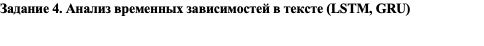

Задача - предсказание следующего слова

In [ ]:
# Импорт библиотек
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import brown
import time
import nltk

# Загрузка корпуса текстов
nltk.download('brown')

# Подготовка текстовых данных
corpus = brown.sents(categories='news')  # Используем категорию "news" для демонстрации
texts = [' '.join(sentence).lower() for sentence in corpus]  # Преобразуем в lowercase строки

# Токенизация текста
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
total_words = len(tokenizer.word_index) + 1

# Создание последовательностей
input_sequences = []
for line in texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Приведение всех последовательностей к одинаковой длине
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Разделение на данные и метки
X, y = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Функция для создания модели
def create_model(rnn_type='LSTM'):
    model = Sequential([
        Embedding(total_words, 100, input_length=max_sequence_len-1),
        (LSTM(150) if rnn_type == 'LSTM' else GRU(150)),
        Dense(total_words, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Раннее завершение обучения
early_stop = EarlyStopping(monitor='loss', patience=3)

# Обучение модели с LSTM
lstm_model = create_model('LSTM')
start_time = time.time()
lstm_history = lstm_model.fit(X, y, epochs=20, verbose=2, callbacks=[early_stop], batch_size=128)
lstm_time = time.time() - start_time

# Обучение модели с GRU
gru_model = create_model('GRU')
start_time = time.time()
gru_history = gru_model.fit(X, y, epochs=20, verbose=2, callbacks=[early_stop], batch_size=128)
gru_time = time.time() - start_time

# Сравнение результатов
print("\nСравнение времени обучения:")
print(f"LSTM: {lstm_time:.2f} секунд")
print(f"GRU: {gru_time:.2f} секунд")

# Построение графиков для анализа
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['loss'], label='Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_history(lstm_history, 'LSTM Model Performance')
plot_history(gru_history, 'GRU Model Performance')


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!



Training LSTM Model...
Epoch 1/10, Loss: 0.6472, Accuracy: 0.9848
Epoch 2/10, Loss: 0.0015, Accuracy: 1.0000
Epoch 3/10, Loss: 0.0009, Accuracy: 1.0000
Epoch 4/10, Loss: 0.0006, Accuracy: 1.0000
Epoch 5/10, Loss: 0.0004, Accuracy: 1.0000
Epoch 6/10, Loss: 0.0003, Accuracy: 1.0000
Epoch 7/10, Loss: 0.0002, Accuracy: 1.0000
Epoch 8/10, Loss: 0.0002, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0001, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0001, Accuracy: 1.0000


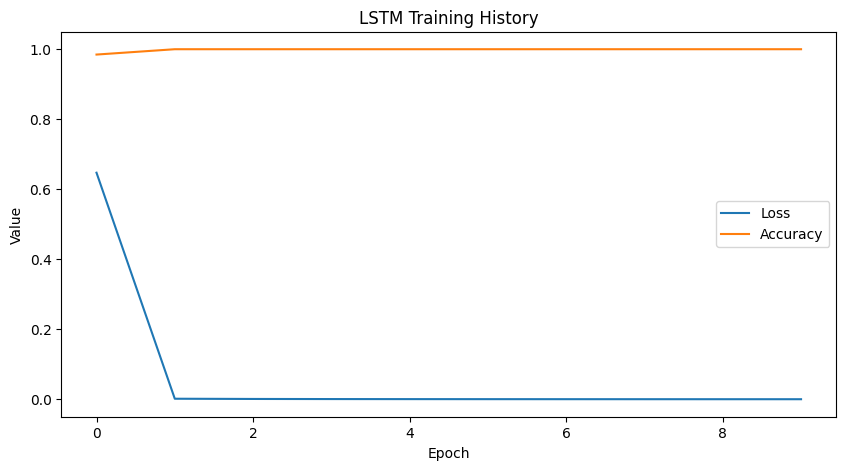


Training GRU Model...
Epoch 1/10, Loss: 0.4934, Accuracy: 0.9848
Epoch 2/10, Loss: 0.0029, Accuracy: 1.0000
Epoch 3/10, Loss: 0.0016, Accuracy: 1.0000
Epoch 4/10, Loss: 0.0010, Accuracy: 1.0000
Epoch 5/10, Loss: 0.0007, Accuracy: 1.0000
Epoch 6/10, Loss: 0.0005, Accuracy: 1.0000
Epoch 7/10, Loss: 0.0004, Accuracy: 1.0000
Epoch 8/10, Loss: 0.0003, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0003, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0002, Accuracy: 1.0000


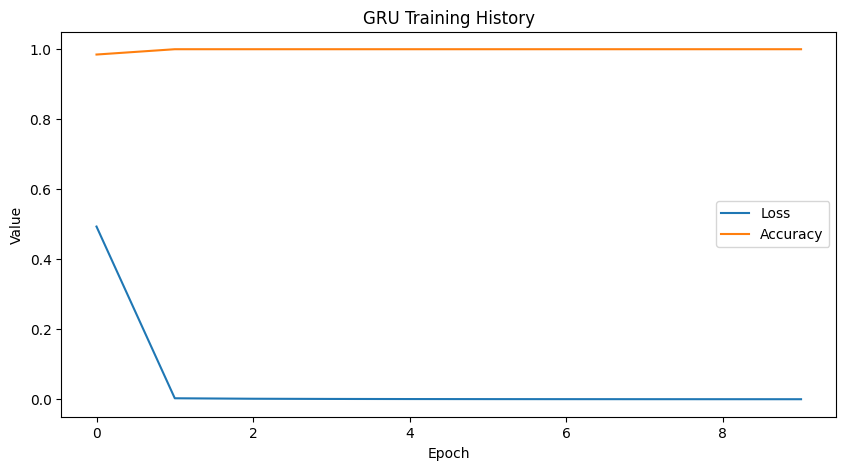

Input: 'the president of the'
Predicted next word (LSTM): '<unk>'
Predicted next word (GRU): '<unk>'
Input: 'the government has'
Predicted next word (LSTM): '<unk>'
Predicted next word (GRU): '<unk>'


In [9]:
# Импорт библиотек
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import brown
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import nltk
import matplotlib.pyplot as plt
from collections import Counter

# Загрузка корпуса текстов
nltk.download('brown')

# Подготовка текстовых данных
corpus = brown.sents(categories='news')[:1000]  # Используем категорию "news" для демонстрации
texts = [' '.join(sentence).lower() for sentence in corpus]  # Преобразуем в lowercase строки

# Токенизация текста

# Создаем словарь токенов
all_words = [word for text in texts for word in text.split()]
word_counts = Counter(all_words)
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common(5000))}  # Увеличен размер словаря
# Словарь с токенами
vocab_size = len(vocab) + 1  # Размер словаря

# Функция для преобразования текста в последовательности индексов
def text_to_sequences(texts, vocab):
    sequences = []
    for text in texts:
        tokenized = [vocab[word] for word in text.split() if word in vocab]
        for i in range(1, len(tokenized)):
            sequences.append(tokenized[:i+1])
    return sequences

# Создание последовательностей
input_sequences = text_to_sequences(texts, vocab)

# Приведение всех последовательностей к одинаковой длине
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = [seq + [0] * (max_seq_len - len(seq)) for seq in input_sequences]

# Преобразование в массивы и разделение на X и y
input_sequences = np.array(input_sequences)
X, y = input_sequences[:, :-1], input_sequences[:, -1]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Устройство для вычислений
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Создание собственного Dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создание DataLoader
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Модель RNN (LSTM или GRU)
class RNNModel(nn.Module):
    def __init__(self, rnn_type='LSTM', vocab_size=1000, embed_size=100, hidden_size=150, output_size=1000):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True) if rnn_type == 'LSTM' else nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        if isinstance(hidden, tuple):  # Если LSTM, берем hidden state
            hidden = hidden[0]
        x = self.fc(hidden.squeeze(0))
        return x

# Функция обучения модели с сохранением истории
def train_model_with_history(model, loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    history = {'loss': [], 'accuracy': []}
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            epoch_acc += (preds == y_batch).sum().item()
        avg_loss = epoch_loss / len(loader)
        avg_acc = epoch_acc / len(loader.dataset)
        history['loss'].append(avg_loss)
        history['accuracy'].append(avg_acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")
    return history
# График обучения

def plot_training_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Loss')
    plt.plot(history['accuracy'], label='Accuracy')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Обучение LSTM модели
lstm_model = RNNModel(rnn_type='LSTM', vocab_size=vocab_size, output_size=vocab_size)
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

print("\nTraining LSTM Model...")
lstm_history = train_model_with_history(lstm_model, train_loader, lstm_criterion, lstm_optimizer, DEVICE)

# Построение графика для LSTM
plot_training_history(lstm_history, "LSTM Training History")

# Обучение GRU модели
gru_model = RNNModel(rnn_type='GRU', vocab_size=vocab_size, output_size=vocab_size)
gru_criterion = nn.CrossEntropyLoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

print("\nTraining GRU Model...")
gru_history = train_model_with_history(gru_model, train_loader, gru_criterion, gru_optimizer, DEVICE)

# Построение графика для GRU
plot_training_history(gru_history, "GRU Training History")

# Проверка модели на тестовом примере
def predict_next_word(model, input_text, tokenizer, vocab, device):
    model.eval()
    with torch.no_grad():
        tokenized_input = [vocab[word] for word in input_text.split() if word in vocab]
        input_seq = torch.tensor([tokenized_input[-(max_seq_len-1):]], dtype=torch.long).to(device)
        output = model(input_seq)
        predicted_idx = torch.argmax(output, dim=1).item()
        word_to_idx = {idx: word for word, idx in vocab.items()}
        predicted_word = word_to_idx.get(predicted_idx, "<unk>")
    return predicted_word

# Пример тестового ввода
test_sentence = "the president of the"
predicted_word = predict_next_word(lstm_model, test_sentence, tokenizer=None, vocab=vocab, device=DEVICE)
print(f"Input: '{test_sentence}'")
print(f"Predicted next word (LSTM): '{predicted_word}'")

predicted_word = predict_next_word(gru_model, test_sentence, tokenizer=None, vocab=vocab, device=DEVICE)
print(f"Predicted next word (GRU): '{predicted_word}'")


# Пример тестового ввода
test_sentence = "the government has"
predicted_word = predict_next_word(lstm_model, test_sentence, tokenizer=None, vocab=vocab, device=DEVICE)
print(f"Input: '{test_sentence}'")
print(f"Predicted next word (LSTM): '{predicted_word}'")

predicted_word = predict_next_word(gru_model, test_sentence, tokenizer=None, vocab=vocab, device=DEVICE)
print(f"Predicted next word (GRU): '{predicted_word}'")